# Data Preparation

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor, KNNBasic

# from sklearn.model_selection import train_test_split

plt.style.use('fast')
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', 50)

Read in the `out` file which is the data prepared for the collaborative modeling in the `FinalDataPreparation` notebook.

In [5]:
transactions = pd.read_csv('Data/out.zip')
transactions.head(3)

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought
0,2020-09-14,0008968c0d451dbc5a9968da03196fe20051965edde741...,893059004,0.035576,2,2020-09-14,2020-09-14,1
1,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,902802002,0.033881,2,2020-09-03,2020-09-03,1
2,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,805000007,0.050831,2,2020-09-03,2020-09-03,1


In [6]:
transactions.shape

(671674, 8)

In [30]:
transactions.customer_id[1]

'002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc'

In [80]:
transactions.customer_id[1000]

'0f1bdcfc0f97380f8221bee6f2c67609e0670331d11f02dd46102e7b048c27b2'

Transactions data description:

- t_dat : A unique identifier of every customer
- customer_id : A unique identifier of every customer (in customers table)
- article_id : A unique identifier of every article (in articles table)
- price : Price of purchase
- sales_channel_id : 1 or 2

### Surprise Data & Split 

In [8]:
# Instantiate reader the same convention as a sklearn class
reader = Reader(rating_scale = (0,1))
# Load user_data from imported dataframe specifiyng which columns to use
customer_data = Dataset.load_from_df(transactions[['customer_id', 'article_id', 'bought']], reader)

In [9]:
type(customer_data)

surprise.dataset.DatasetAutoFolds

In [10]:
# Perform an appropriate split for the recommendation models
trainset, testset = train_test_split(customer_data, test_size=0.2, random_state=42)

In [11]:
#How many users and items are in the trainset
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  172712 

Number of items:  9225 



## Modeling

### Baselines without cross validation

In [12]:
# Instantiate and fit model
baseline = NormalPredictor()
baseline.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline.test(testset)

# Save RMSE score to variable
baseline_normal = accuracy.rmse(predictions)

RMSE: 0.0000


In [13]:
# Instantiate and fit model
baseline2 = BaselineOnly()
baseline2.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline2.test(testset)

# Save RMSE score to variable
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.0000


### SVD

In [36]:
svd_model = SVD()
svd_model.fit(trainset)
svd_predictions = svd_model.test(testset)
svd_simple_predictions = accuracy.rmse(svd_predictions)
svd_simple_predictions

RMSE: 0.0463


0.04634143319111156

In [37]:
svd_model.predict('0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2', 902802002)

Prediction(uid='0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2', iid=902802002, r_ui=None, est=0.8988532711706756, details={'was_impossible': False})

In [38]:
transactions.loc[(transactions['customer_id'] == '0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2') & 
                 (transactions['article_id'] == 902802002)]

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought


In [ ]:
param_grid = {'n_factors':[10,50],'n_epochs': [5, 15], 'lr_all': [0.002,0.01],
             'reg_all': [0.2,0.6]}
gs_model_SVD1 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD1.fit(customer_data)

gs_model_SVD1.best_params

explain

In [ ]:
param_grid2 = {'n_factors':[5,10],'n_epochs': [15, 50], 'lr_all': [0.001, 0.01],
             'reg_all': [0.6, 0.8]}
gs_model_SVD2 = GridSearchCV(SVD,param_grid=param_grid2,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD2.fit(customer_data)

gs_model_SVD2.best_params

explain

In [ ]:
param_grid3 = {'n_factors':[10],'n_epochs': [50, 100], 'lr_all': [0.1, 0.2],
             'reg_all': [0.8, 0.9]}
gs_model_SVD3 = GridSearchCV(SVD,param_grid=param_grid3,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD3.fit(customer_data)

gs_model_SVD3.best_params

In [ ]:
param_grid4 = {'n_factors':[10],'n_epochs': [100, 150], 'lr_all': [0.2, 0.3],
             'reg_all': [0.7, 0.8]}
gs_model_SVD4 = GridSearchCV(SVD,param_grid=param_grid4,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD4.fit(customer_data)

gs_model_SVD4.best_params

We find the best parameters for SVD modeling are - 
- n_factors : 10
- n_epochs : 100
- lr_all :0.2
- reg_all : 0.8

Now we build a model with the best parameters and test it on our testset.

In [39]:
svd_model2 = SVD(n_factors= 10, n_epochs= 50)
svd_model2.fit(trainset)
svd_predictions2 = svd_model2.test(testset)
svd_tuned_predictions = accuracy.rmse(svd_predictions2)
svd_tuned_predictions

RMSE: 0.0115


0.011460277893248154

### NFM 

Now, we explore the `Non-negative Matrix Factorization (NMF)` from the `suprise` library. The only difference between this algorithm and the previous algorithm SVD is that in NMF, a specific step size is set for the stochastic gradient descent process of regularization. This is done to ensure that all user and item factors are kept positive. While this model can be prone to over-fitting, this can be mitigated with steps to reduce the dimensionality of our data/factors.

In [18]:
nmf_model = NMF()
nmf_model.fit(trainset)
nmf_predictions = nmf_model.test(testset)
nmf_simple_predictions = accuracy.rmse(nmf_predictions)
nmf_simple_predictions

RMSE: 0.0676


0.0676350352956524

In [ ]:
param_grid = {'n_factors':[10,15,20],'n_epochs': [25, 50, 75]}
gs_model_NFM = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_NFM.fit(customer_data)

gs_model_NFM.best_params

explain

In [ ]:
param_grid = {'n_factors':[10],'n_epochs': [75, 100]}
gs_model_NFM2 = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_NFM2.fit(customer_data)

gs_model_NFM2.best_params

Explain

We find the best parameters for NMF modeling are - 
- n_factors : 10
- n_epochs : 100

Now we build a model with the best parameters and test it on our testset.

In [19]:
nmf_model2 = NMF(n_factors = 10, n_epochs = 100)
nmf_model2.fit(trainset)
nmf_predictions2 = nmf_model2.test(testset)
nmf_tuned_predictions = accuracy.rmse(nmf_predictions2)

nmf_tuned_predictions

RMSE: 0.0582


0.05823298887397602

## SVD ++ 

For a final look at models from the `surprise` library, I wanted to try and utilize the SVD++ algorithm, again, very similar to SVD. The difference is that SVD++ attempts to add an extension onto the base SVD that uses implicit rating as well as explicit. In other words it infers the action of rating an item as a latent factor regardless of the rating value given to the item while also factoring the actual rating value. I thought this might further improve the RMSE by taking into account reviewers who have rated a large number of eBooks. Please note that this Grid Search will take a very long time to run.

In [20]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_model = SVDpp()
SVDpp_model.fit(trainset)
SVDpp_predictions = SVDpp_model.test(testset)
svdpp_simple_predictions = accuracy.rmse(SVDpp_predictions)

svdpp_simple_predictions

RMSE: 0.0206


0.020647204882569048

In [ ]:
# New dictionary for SVD++
svdpp_param_grid = {'n_factors':[1, 5], 'n_epochs':[25, 50], 'reg_all':[0.02, 0.05]}
svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=5, n_jobs=-2, measures=['RMSE'])

# Fit and return the best_params based on cross validation this will take a VERY long time to run
svdpp_gs_model.fit(customer_data)

svdpp_gs_model.best_params

explain

In [ ]:
# New dictionary for SVD++
svdpp_param_grid2 = {'n_factors':[1], 'n_epochs':[50, 100], 'reg_all':[0.05, 0.1]}
svdpp_gs_model2 = GridSearchCV(SVDpp, param_grid=svdpp_param_grid2, cv=3, joblib_verbose=5, n_jobs=-2, measures=['RMSE'])

# Fit and return the best_params based on cross validation this will take a VERY long time to run
svdpp_gs_model2.fit(customer_data)

svdpp_gs_model2.best_params

We find the best parameters for SVD ++ modeling are - 
- n_factors : 1
- n_epochs : 100
- reg_all : 0.1

Now we build a model with the best parameters and test it on our testset.

In [22]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_model2 = SVDpp(n_factors=1, n_epochs=100, reg_all=0.1)
SVDpp_model2.fit(trainset)
SVDpp_predictions2 = SVDpp_model2.test(testset)
svdpp_tuned_predictions = accuracy.rmse(SVDpp_predictions2)

svdpp_tuned_predictions

RMSE: 0.0008


0.0008434432468881647

## Model Performance

In [23]:
# # just to code ahead! 
baseline_only = 0.00
svd_simple_predictions = 0.0463
svd_tuned_predictions = 0.0115
nmf_simple_predictions = 0.0676
nmf_tuned_predictions = 0.0582
svdpp_simple_predictions = 0.0206
svdpp_tuned_predictions = 0.0207

In [24]:
X = ['Baseline', 'SVD Basic', 'SVD Tuned', 'NMF Basic', 'NMF tuned', 'SVD ++ Basic', 'SVD ++ Tuned']
y = [baseline_only, svd_simple_predictions, svd_tuned_predictions, nmf_simple_predictions, nmf_tuned_predictions, svdpp_simple_predictions, svdpp_tuned_predictions]

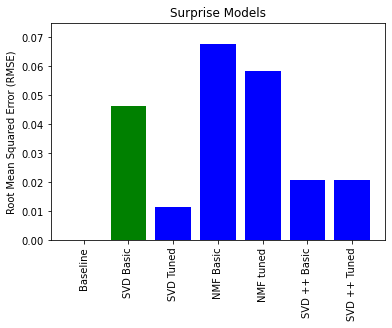

In [26]:
fig, ax = plt.subplots()
plt.bar(X, y, color=['black', 'green', 'blue', 'blue', 'blue', 'blue', 'blue'])
plt.xticks(rotation=90)
plt.ylim(0, .075)
plt.grid(False)
ax.set_title("Surprise Models")
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.savefig('Images/Model_bar.png', dpi=500, bbox_inches='tight');

# Recommendation Function

### Building

##### Final Model

In [37]:
# Using Surprise a full trainset incorporating all data can be built and fit to the model in order to make full predictions
trainset_full = customer_data.build_full_trainset()

In [38]:
final_model = SVD(n_factors= 10, n_epochs= 50)
final_model.fit(trainset_full)

In [39]:
# The model is pickled and saved into the Model folder in the repository so it can used in the app.py file
pickle.dump(final_model, open('Model/collaborative_model.sav', 'wb'))

In [40]:
collab_model = pickle.load(open('Model/collaborative_model.sav', 'rb'))

In [41]:
transactions.tail(10)

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought
671664,2020-09-22,ff732b98019465f078144bae647d7d9765d76e3431ef926a7c5064783f7027a6,651591001,0.032186,2,2020-09-22,2020-09-22,1
671665,2020-09-22,ff732b98019465f078144bae647d7d9765d76e3431ef926a7c5064783f7027a6,864339003,0.022017,2,2020-09-22,2020-09-22,1
671666,2020-09-22,ff732b98019465f078144bae647d7d9765d76e3431ef926a7c5064783f7027a6,938667001,0.010153,2,2020-09-22,2020-09-22,1
671667,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,762846006,0.025407,2,2020-09-22,2020-09-22,1
671668,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,762846027,0.025407,2,2020-09-22,2020-09-22,1
671669,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,914404001,0.042356,2,2020-09-22,2020-09-22,1
671670,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,751471041,0.033881,2,2020-09-22,2020-09-22,1
671671,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,751471038,0.033881,2,2020-09-22,2020-09-22,1
671672,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1dfd2f8586a5ce3ce8bf4,895730002,0.045746,2,2020-09-22,2020-09-22,1
671673,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1dfd2f8586a5ce3ce8bf4,740519002,0.045746,2,2020-09-22,2020-09-22,1


Start from here... 
- we have to load the articles df here as meta data with article id as the index 
- build function

In [43]:
# Load in the meta data for use in returning the details about the recommended articles 
meta_articles = pd.read_csv('Data/articles.csv.zip', index_col='article_id')
meta_articles.head(3)

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [44]:
# sanity check
meta_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105542 entries, 108775015 to 959461001
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   product_code                  105542 non-null  int64 
 1   prod_name                     105542 non-null  object
 2   product_type_no               105542 non-null  int64 
 3   product_type_name             105542 non-null  object
 4   product_group_name            105542 non-null  object
 5   graphical_appearance_no       105542 non-null  int64 
 6   graphical_appearance_name     105542 non-null  object
 7   colour_group_code             105542 non-null  int64 
 8   colour_group_name             105542 non-null  object
 9   perceived_colour_value_id     105542 non-null  int64 
 10  perceived_colour_value_name   105542 non-null  object
 11  perceived_colour_master_id    105542 non-null  int64 
 12  perceived_colour_master_name  105542 non-null  

In [45]:
transactions.head()

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought
0,2020-09-14,0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2,893059004,0.035576,2,2020-09-14,2020-09-14,1
1,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,902802002,0.033881,2,2020-09-03,2020-09-03,1
2,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000007,0.050831,2,2020-09-03,2020-09-03,1
3,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,918292001,0.042356,2,2020-09-03,2020-09-03,1
4,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000001,0.050831,2,2020-09-03,2020-09-03,1


In [46]:
# The transactions data is subset to just show customers and the articles they have bought
df_customer = transactions.set_index('customer_id')
df_customer.drop(columns=['InvoiceDate', 'price', 'sales_channel_id', 't_dat', 'date', 'bought'], inplace=True)
df_customer.head()

,article_id
customer_id,
0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2,893059004
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,902802002
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000007
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,918292001
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000001


In [47]:
# Save the `df_customer` as a new csv

df_customer.to_csv('Data/df_customer.csv')

In [48]:
pd.read_csv('Data/df_customer.csv', index_col='customer_id')

,article_id
customer_id,
0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2,893059004
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,902802002
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000007
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,918292001
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000001
...,...
ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,914404001
ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,751471041
ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,751471038


In [49]:
# Dual input for unique customer ID and how many recommendations you would like
customer = input('CustomerID: ')
n_recs = int(input('How many recommendations? '))

CustomerID: 002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc
How many recommendations? 10


In [54]:
# Creating a list of the eBooks that said reviewer has already rated
have_bought = list(df_customer.loc[customer, 'article_id'])

In [55]:
# Creating new dataframe from meta data to subset based on already bought articles
not_bought = meta_articles.copy()
# Dropping indexes (article_id) that correspond to already bought articles
not_bought.drop(have_bought, inplace=True)
# Reset index to pull out article_id as a seperate column
not_bought.reset_index(inplace=True)
not_bought.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [56]:
# Obtain rating predictions based on model.predict, passing in user input. 
# Using .apply with lamdba function to iterate through
not_bought['est_purchase'] = not_bought['article_id'].apply(lambda x: final_model.predict(customer, x).est)
# Sort dataframe based on newly created est_purchase problem in order to return top estimated ratings (purcahse in this case)
not_bought.sort_values(by='est_purchase', ascending=False, inplace=True)
not_bought.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,est_purchase
75250,780418001,780418,Stina scarf new,80,Scarf,Accessories,1010016,Solid,9,Black,4,Dark,5,Black,3945,Knit & Woven,D,Divided,2,Divided,52,Divided Accessories,1019,Accessories,"Scarf in a soft, fine knit with fringes on the short sides.",1.0
98229,878183001,878183,PU Radiator jacket,262,Jacket,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1201,Outwear,A,Ladieswear,1,Ladieswear,19,Womens Jackets,1007,Outdoor,"Straight-cut jacket in grained imitation leather with a collar, zip and wind flap with concealed press-studs down the front. Dropped shoulders and long sleeves with an adjustable tab and press-stud at the cuffs. Detachable tie belt at the waist, flap chest pockets and pockets in the side seams. Lined.",1.0
98230,878183003,878183,PU Radiator jacket,262,Jacket,Garment Upper body,1010016,Solid,17,Yellowish Brown,4,Dark,13,Brown,1201,Outwear,A,Ladieswear,1,Ladieswear,19,Womens Jackets,1007,Outdoor,"Straight-cut jacket in grained imitation leather with a collar, zip and wind flap with concealed press-studs down the front. Dropped shoulders and long sleeves with an adjustable tab and press-stud at the cuffs. Detachable tie belt at the waist, flap chest pockets and pockets in the side seams. Lined.",1.0
102371,903644001,903644,WILDA BELT,67,Belt,Accessories,1010016,Solid,9,Black,4,Dark,5,Black,3948,Other Accessories,D,Divided,2,Divided,52,Divided Accessories,1019,Accessories,Waist belt in imitation leather with a metal buckle. Width 2.4 cm.,1.0
98238,878223001,878223,Phoenix hip,67,Belt,Accessories,1010016,Solid,33,Dark Orange,2,Medium Dusty,13,Brown,3509,Belts,C,Ladies Accessories,1,Ladieswear,65,Womens Big accessories,1019,Accessories,Belt in imitation suede with a metal buckle and metal appliqués in the shape of shells and starfish. Width 2.5 cm.,1.0


In [57]:
not_bought['est_purchase'].tail()

101073    0.938635
90506     0.935236
95218     0.934651
91527     0.929744
74385     0.926150
Name: est_purchase, dtype: float64

In [58]:
# Captilizing column names for a more appealing final display
not_bought.rename(columns={'prod_name':'Product Name', 'author':'Author',
                               'product_type_name':'Product Type Name', 'product_group_name':'Product Group Name',
                               'index_group_name':'Index Group Name', 'garment_group_name ':'Garment Group Name'}, inplace=True)

In [59]:
# Final step is to only return the top n_recs as denoted by input, done using .head(n_recs)
not_bought.head(n_recs)

,article_id,product_code,Product Name,product_type_no,Product Type Name,Product Group Name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,Index Group Name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,est_purchase
75250,780418001,780418,Stina scarf new,80,Scarf,Accessories,1010016,Solid,9,Black,4,Dark,5,Black,3945,Knit & Woven,D,Divided,2,Divided,52,Divided Accessories,1019,Accessories,"Scarf in a soft, fine knit with fringes on the short sides.",1.0
98229,878183001,878183,PU Radiator jacket,262,Jacket,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1201,Outwear,A,Ladieswear,1,Ladieswear,19,Womens Jackets,1007,Outdoor,"Straight-cut jacket in grained imitation leather with a collar, zip and wind flap with concealed press-studs down the front. Dropped shoulders and long sleeves with an adjustable tab and press-stud at the cuffs. Detachable tie belt at the waist, flap chest pockets and pockets in the side seams. Lined.",1.0
98230,878183003,878183,PU Radiator jacket,262,Jacket,Garment Upper body,1010016,Solid,17,Yellowish Brown,4,Dark,13,Brown,1201,Outwear,A,Ladieswear,1,Ladieswear,19,Womens Jackets,1007,Outdoor,"Straight-cut jacket in grained imitation leather with a collar, zip and wind flap with concealed press-studs down the front. Dropped shoulders and long sleeves with an adjustable tab and press-stud at the cuffs. Detachable tie belt at the waist, flap chest pockets and pockets in the side seams. Lined.",1.0
102371,903644001,903644,WILDA BELT,67,Belt,Accessories,1010016,Solid,9,Black,4,Dark,5,Black,3948,Other Accessories,D,Divided,2,Divided,52,Divided Accessories,1019,Accessories,Waist belt in imitation leather with a metal buckle. Width 2.4 cm.,1.0
98238,878223001,878223,Phoenix hip,67,Belt,Accessories,1010016,Solid,33,Dark Orange,2,Medium Dusty,13,Brown,3509,Belts,C,Ladies Accessories,1,Ladieswear,65,Womens Big accessories,1019,Accessories,Belt in imitation suede with a metal buckle and metal appliqués in the shape of shells and starfish. Width 2.5 cm.,1.0
76869,786925004,786925,Calista.,245,Cardigan,Garment Upper body,1010016,Solid,43,Dark Red,4,Dark,18,Red,1616,Knitwear,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1003,Knitwear,"Cardigan in a soft, fine-knit viscose blend with a round neck and buttons down the front.",1.0
98248,878293001,878293,Willow pletated midi skirt,275,Skirt,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1444,Skirts,D,Divided,2,Divided,53,Divided Collection,1012,Skirts,"Calf-length, pleated skirt in woven fabric with a sewn-in wrapover at the front, covered elastication at the waist and overlocked edges. Longer at the back. Unlined.",1.0
98250,878293003,878293,Willow pletated midi skirt,275,Skirt,Garment Lower body,1010016,Solid,53,Dark Pink,4,Dark,4,Pink,1444,Skirts,D,Divided,2,Divided,53,Divided Collection,1012,Skirts,"Calf-length, pleated skirt in woven fabric with a sewn-in wrapover at the front, covered elastication at the waist and overlocked edges. Longer at the back. Unlined.",1.0
102365,903590001,903590,Bernie HW Jogger,272,Trousers,Garment Lower body,1010001,All over pattern,12,Light Beige,1,Dusty Light,11,Beige,4091,Price Items,D,Divided,2,Divided,50,Divided Projects,1001,Unknown,"Trousers in patterned sweatshirt fabric with an appliqué at the top. Relaxed fit with a high, elasticated, drawstring waist, discreet pockets in the side seams, and gently tapered legs with ribbed hems. Soft brushed inside. The polyester content of the sweatpants is recycled.",1.0
91915,851774008,851774,Heaven high support shape bra,306,Bra,Underwear,1010016,Solid,8,Dark Grey,4,Dark,5,Black,8316,Ladies Sport Bras,S,Sport,26,Sport,5,Ladies H&M Sport,1005,Jersey Fancy,"Fully lined sports bra in extra-sturdy, fast-drying functional fabric that shapes and scu

In [76]:
not_bought.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105536 entries, 75250 to 74385
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   article_id                    105536 non-null  int64  
 1   product_code                  105536 non-null  int64  
 2   Product Name                  105536 non-null  object 
 3   product_type_no               105536 non-null  int64  
 4   Product Type Name             105536 non-null  object 
 5   Product Group Name            105536 non-null  object 
 6   graphical_appearance_no       105536 non-null  int64  
 7   graphical_appearance_name     105536 non-null  object 
 8   colour_group_code             105536 non-null  int64  
 9   colour_group_name             105536 non-null  object 
 10  perceived_colour_value_id     105536 non-null  int64  
 11  perceived_colour_value_name   105536 non-null  object 
 12  perceived_colour_master_id    105536 non-

## Function

In [85]:
def customer_article_recommend():
    
    user = input('CustomerID: ')
    n_recs = int(input('How many recommendations? '))
    
    have_bought = list(df_customer.loc[customer, 'article_id'])
    not_bought = meta_articles.copy()
    not_bought.drop(have_bought, inplace=True)
    not_bought.reset_index(inplace=True)
    not_bought['est_purchase'] = not_bought['article_id'].apply(lambda x: final_model.predict(customer, x).est)
    not_bought.sort_values(by='est_purchase', ascending=False, inplace=True)
    
    not_bought.rename(columns={'prod_name':'Product Name','product_type_name':'Product Type Name', 'product_group_name':'Product Group Name',
                               'index_group_name':'Index Group Name', 'garment_group_name':'Garment Group Name'}, inplace=True)
    not_bought = not_bought[['article_id','Product Name', 'Product Type Name', 'Product Group Name', 'Index Group Name', 'Garment Group Name']]
    not_bought = not_bought.sample(frac=0.001).reset_index(drop=True)
    return not_bought.head(n_recs)

## Evaluation

In [86]:
customer_article_recommend()

CustomerID: 002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc
How many recommendations? 10


,article_id,Product Name,Product Type Name,Product Group Name,Index Group Name,Garment Group Name
0,626813003,Syrup ISW 19,Blouse,Garment Upper body,Ladieswear,Blouses
1,777229004,Rick cardigan,Cardigan,Garment Upper body,Menswear,Knitwear
2,867837005,APRIL TIE BLOUSE S.L,Vest top,Garment Upper body,Baby/Children,Dresses/Skirts girls
3,609176002,Maja sneaker NEW,Sneakers,Shoes,Divided,Shoes
4,692834007,TP Tom chino shorts,Shorts,Garment Lower body,Baby/Children,Shorts
5,877429001,Sally shopper,Bag,Accessories,Ladieswear,Accessories
6,735751004,Milan Fringe,Jacket,Garment Upper body,Divided,Outdoor
7,874351004,Tyron waist chino,Trousers,Garment Lower body,Baby/Children,Woven/Jersey/Knitted mix Baby
8,702198004,cleo tunic,Blouse,Garment Upper body,Baby/Children,Dresses/Skirts girls
9,510684017,Lory sweatpants,Trousers,Garment Lower body,Divided,Jersey Fancy


In [87]:
customer_article_recommend()

CustomerID: 0f1bdcfc0f97380f8221bee6f2c67609e0670331d11f02dd46102e7b048c27b2
How many recommendations? 10


,article_id,Product Name,Product Type Name,Product Group Name,Index Group Name,Garment Group Name
0,761400001,ES Melker trousers,Shorts,Garment Lower body,Baby/Children,Trousers
1,909529001,SPORT Harmony loose tee,Top,Garment Upper body,Ladieswear,Jersey Fancy
2,596950005,2P SS Body fancy,Bodysuit,Garment Upper body,Baby/Children,Jersey Basic
3,407354009,Jack jersey denim,Hoodie,Garment Upper body,Menswear,Outdoor
4,551045002,Printed Hood 24.99,Hoodie,Garment Upper body,Menswear,Jersey Fancy
5,559854004,Rodnay fancy/fun,Hat/beanie,Accessories,Divided,Accessories
6,801111002,BEST SIS toto set,Garment Set,Garment Full body,Baby/Children,Jersey Fancy
7,575495003,Monet wide trouser,Trousers,Garment Lower body,Ladieswear,Trousers
8,636588004,Sigge Shorts,Shorts,Garment Lower body,Menswear,Jersey Basic
9,675581008,Cora chenille,Sweater,Garment Upper body,Baby/Children,Knitwear


## Conclusion